In [1]:
import numpy as np
import torch
from ADEN import ADEN
from torchinfo import summary
from TestCaseGenerator import data_RLClustering
from ADENTrain import TrainAnneal
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading Data

In [2]:
X, M, T_P, N, d = data_RLClustering(4)
X = torch.tensor(X).float().to(device)
Y = torch.mean(X, dim=0).to(device) + torch.randn(M, d).to(
    device
)  # example cluster tensor (M, d)

# Loading ADEN Model

In [12]:

INPUT_DIM = d  # dimensionality of the input space
D_MODEL = 64  # dimensionality of the model
N_LAYERS = 4  # number of layers
N_HEADS = 8  # number of attention heads
D_FF = 128  # dimensionality of the feedforward network
DROPOUT = 0.05  # dropout rate

model = ADEN(
    input_dim=INPUT_DIM,
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_ff=D_FF,
    dropout=DROPOUT,
    device=device
)

print(summary(model))

Layer (type:depth-idx)                             Param #
ADEN                                               --
├─Linear: 1-1                                      192
├─Linear: 1-2                                      192
├─ModuleList: 1-3                                  --
│    └─AdaptiveDistanceBlock: 2-1                  --
│    │    └─MultiHeadDistanceAttention: 3-1        16,448
│    │    └─LayerNorm: 3-2                         128
│    │    └─LayerNorm: 3-3                         128
│    │    └─Sequential: 3-4                        16,576
│    │    └─Dropout: 3-5                           --
│    └─AdaptiveDistanceBlock: 2-2                  --
│    │    └─MultiHeadDistanceAttention: 3-6        16,448
│    │    └─LayerNorm: 3-7                         128
│    │    └─LayerNorm: 3-8                         128
│    │    └─Sequential: 3-9                        16,576
│    │    └─Dropout: 3-10                          --
│    └─AdaptiveDistanceBlock: 2-3                  --
│

# Main Annealing Loop

In [13]:
# writing all hyperparameters in one place
EPOCHS_DBAR = 5000 
BATCH_SIZE_DBAR = 32
NUM_SAMPLES_IN_BATCH_DBAR = 128
LR_DBAR = 1e-4
WEIGHT_DECAY_DBAR = 1e-5
TOL_TRAIN_DBAR = 1e-6
GAMMA_DBAR = 1000.0
PROBS_DBAR = torch.tensor(T_P)

EPOCHS_TRAIN_Y = 5000 # 100 
BATCH_SIZE_TRAIN_Y = None
LR_TRAIN_Y = 1e-3 # 5e-4
WEIGHT_DECAY_TRAIN_Y = 1e-5
TOL_TRAIN_Y = 1e-4

BETA_INIT = 1e-2
BETA_F = 1500.0
BETA_GROWTH_RATE = 1.5 
PERTURBATION_STD = 0.5 # 0.2


Y_opt, history_y_all, history_pi_all = TrainAnneal(
    model,
    X,
    Y,
    device,
    # TrainDbar hyperparameters
    epochs_dbar=EPOCHS_DBAR,
    batch_size_dbar=BATCH_SIZE_DBAR,
    num_samples_in_batch_dbar=NUM_SAMPLES_IN_BATCH_DBAR,
    lr_dbar=LR_DBAR,
    weight_decay_dbar=WEIGHT_DECAY_DBAR,
    tol_train_dbar=TOL_TRAIN_DBAR,
    gamma_dbar=GAMMA_DBAR,
    probs_dbar=PROBS_DBAR,
    # trainY hyperparameters
    epochs_train_y=EPOCHS_TRAIN_Y,
    batch_size_train_y=BATCH_SIZE_TRAIN_Y,
    lr_train_y=LR_TRAIN_Y,
    weight_decay_train_y=WEIGHT_DECAY_TRAIN_Y,
    tol_train_y=TOL_TRAIN_Y,
    # annealing schedule
    beta_init=BETA_INIT,
    beta_final=BETA_F,
    beta_growth_rate=BETA_GROWTH_RATE,
    perturbation_std=PERTURBATION_STD,
)


=== Annealing step: Beta = 0.0100 ===
[TrainDbar_Hybrid] Epoch 0, MSE Loss: 3.436e+05
[TrainDbar_Hybrid] Epoch 1000, MSE Loss: 1.589e+03
[TrainDbar_Hybrid] Epoch 2000, MSE Loss: 1.188e+03
[TrainDbar_Hybrid] Epoch 3000, MSE Loss: 8.543e+02
[TrainDbar_Hybrid] Epoch 4000, MSE Loss: 7.900e+02
[TrainDbar_Hybrid] Epoch 5000, MSE Loss: 8.130e+02
[trainY] Epoch 0, F: -1.258e+02
[trainY] Converged at epoch 1, F: -1.258e+02

=== Annealing step: Beta = 0.0150 ===
[TrainDbar_Hybrid] Epoch 0, MSE Loss: 3.980e+05
[TrainDbar_Hybrid] Epoch 1000, MSE Loss: 9.613e+02
[TrainDbar_Hybrid] Epoch 2000, MSE Loss: 8.391e+02
[TrainDbar_Hybrid] Epoch 3000, MSE Loss: 8.273e+02
[TrainDbar_Hybrid] Epoch 4000, MSE Loss: 9.750e+02
[TrainDbar_Hybrid] Epoch 5000, MSE Loss: 8.117e+02
[trainY] Epoch 0, F: -7.939e+01
[trainY] Converged at epoch 1, F: -7.939e+01

=== Annealing step: Beta = 0.0225 ===
[TrainDbar_Hybrid] Epoch 0, MSE Loss: 3.872e+05
[TrainDbar_Hybrid] Epoch 1000, MSE Loss: 1.042e+03
[TrainDbar_Hybrid] Epoch

KeyboardInterrupt: 

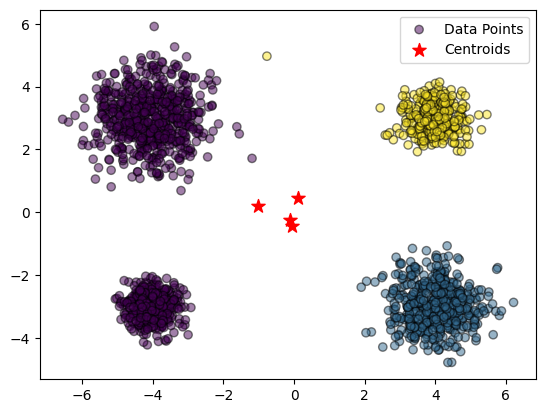

In [11]:
# plot locations of X and final y
import matplotlib.pyplot as plt

pi = history_pi_all[-1]
# converting results to numpy
X_np = X.detach().cpu().numpy()
y_np = Y_opt.detach().cpu().numpy()
plt.scatter(
    X_np[:, 0],
    X_np[:, 1],
    c=pi,
    cmap="viridis",
    marker="o",
    edgecolors="black",
    alpha=0.5,
    label="Data Points",
)
plt.scatter(y_np[:, 0], y_np[:, 1], label="Centroids", marker="*", s=100, color="red")
plt.legend()
plt.savefig("Results/Alg5_idx4_def_clustering_result.png", dpi=400)
plt.show()

In [6]:
from animator import animate_Clusters

animate_Clusters(
    X.detach().cpu().numpy(),
    history_y_all,
    history_pi_all,
    interval=400,
    save_path=f"Results/Deep_animation.gif",
)